# Import Libararies

In [1]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from prettytable import PrettyTable
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve,auc

# Check GPU detected

In [2]:
print(tf.__version__) # Check Enviroment Variable CUDA_VISIBLE_DEVICES
print(tf.config.list_physical_devices()) # Check in the terminal using nvidia-smi to monitor usage

2.5.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Convert the dataset into numpy arrays, or retrieve pickled objects

In [3]:
train=r"C:\Users\omara\originPNG"
category=["healthypng","covidpng"]
data=[]
Model="CT"
for i in category:
    path=os.path.join(train,i)
    label=category.index(i)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        img_arr=cv2.imread(img_path,0)
        data.append([img_arr,label])
random.shuffle(data)
x=[]
y=[]
x_test=[]
y_test=[]
for features,labels in data:
    x.append(features)
    y.append(labels)
    
x_test=np.array(x[int(len(x)*0.9):-1])
y_test=np.array(y[int(len(y)*0.9):-1])

x=np.array(x[0:int(0.9*len(x))])
y=np.array(y[0:int(0.9*len(y))])

x=x/255
x_test=x_test/255

data.clear()

x=x.reshape(len(x),256,256,1)
x_test=x_test.reshape(len(x_test),256,256,1)

# Increase Page file size if Memory_Error occurs

In [ ]:
pickle.dump(x,open('x4.pkl','wb'))
pickle.dump(y,open('y4.pkl','wb'))
pickle.dump(x_test,open('x_test4.pkl','wb'))
pickle.dump(y_test,open('y_test4.pkl','wb'))

In [ ]:
x=pickle.load(open('x4.pkl','rb'))
x_test=pickle.load(open('x_test4.pkl','rb'))
y=pickle.load(open('y4.pkl','rb'))
y_test=pickle.load(open('y_test4.pkl','rb'))

# Build the CNet

In [4]:
def Train():
    # To prevent Resources_Exausted_Error
    model=tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=x.shape[1:],activation="relu",padding="same"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64,activation="relu"))
    model.add(tf.keras.layers.Dropout(0.25))


    model.add(tf.keras.layers.Dense(64,activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(32,activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())


    model.add(tf.keras.layers.Dense(3,activation="softmax"))


    model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['acc']) # or binary_crossentropy

    
    model.fit(x,y,epochs=2,validation_split=0.1,batch_size=32)
    try:
        session.close()
    except:
        print('meh')

    return model

In [5]:
model=Train()

loss,win=model.evaluate(x_test,y_test)
print('===============================================================')
print('loss: {}, acc: {}'.format(loss,win))

model.summary()

Epoch 1/2
50/50 [==============================] - 12s 167ms/step - loss: 0.8695 - acc: 0.6365 - val_loss: 3.7128 - val_acc: 0.3785
Epoch 2/2
50/50 [==============================] - 7s 135ms/step - loss: 0.5622 - acc: 0.8013 - val_loss: 0.4590 - val_acc: 0.8305
meh
7/7 [==============================] - 0s 69ms/step - loss: 0.3881 - acc: 0.8622
loss: 0.3880598545074463, acc: 0.8622449040412903
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)       

# Saving the model after achieving 95% accuracy

In [ ]:
model.save("ULT_CT_XRAY_CONV_V4")

INFO:tensorflow:Assets written to: ULT_CT_XRAY_CONV_V4\assets


In [ ]:
model=tf.keras.models.load_model("ULT_CT_XRAY_CONV_V4")

# Strandradized Table for the model acuuaracy and after 30 runs.

In [ ]:
for i in range(30):
    model=Train()
    test=model.evaluate(x_test,y_test)
    with open(r'avg.txt','a+') as file:
        file.write("{},{}\n".format(test[1],test[0]))

# Confusion Matrix 

C:\Users\omara\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


True


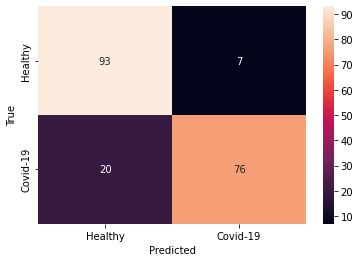

In [7]:
singlepredict=[]
singletest=[]
predict=model.predict([x_test]) # not the best way to get a some neat labels
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())# If false then confusion.numpy will produce error

singlepredict=np.argmax(predict,1) # I forget what it does exactly or how it does it
singletest=np.array(y_test)
confusion=tf.math.confusion_matrix(labels=singletest, predictions=singlepredict).numpy()
#plt.imshow(confusion) # Green Confusion Matrix
sns.heatmap(confusion , annot=True , xticklabels=['Healthy' , 'Covid-19'] , yticklabels=['Healthy' , 'Covid-19'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Metrics

In [8]:
precision, recall, f1, _ = score(singletest, singlepredict)
print('Precision: {},Averge: {}'.format(precision,sum(precision)/len(precision)))
print('Recall: {},Average: {}'.format(recall,sum(recall)/len(recall)))
print('F-score: {},Average: {}'.format(f1,sum(f1)/len(f1)))


Precision: [0.82300885 0.91566265],Averge: 0.8693357500799659
Recall: [0.93       0.79166667],Average: 0.8608333333333333
F-score: [0.87323944 0.84916201],Average: 0.8612007238964514


In [22]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
val_loss = model.history.history['val_loss']
loss = model.history.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, [i*100 for i in acc], 'green', label='Training acc')
plt.plot(epochs,[i*100 for i in val_acc], 'blue', label='Validation acc')

plt.plot(epochs, [i*100 for i in loss], 'red', label='Training loss')
plt.plot(epochs,[i*100 for i in val_loss], 'black', label='Validation loss')
plt.title('Training, validation accuaracy and loss over epochs')#'Training and validation loss'
plt.legend()

plt.show()

KeyError: 'acc'

C:\Users\omara\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


auc = 0.8608333333333332


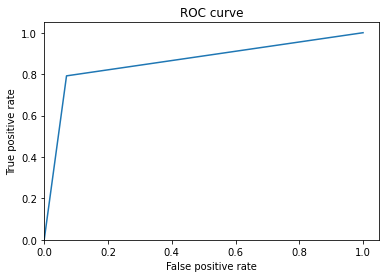

In [9]:
predict=model.predict([x_test])
singlepredict=np.argmax(predict,1)
fpr, tpr, _ = roc_curve(y_test, singlepredict)
auc_rf = auc(fpr, tpr)
print("auc =",auc_rf)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

# Some visulization into some cases in the dataset, the prediction and the true output.

In [ ]:
predict=model.predict([x_test])

C:\Users\omara\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


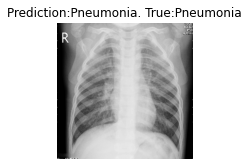

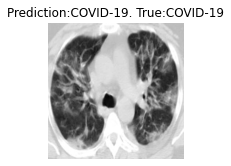

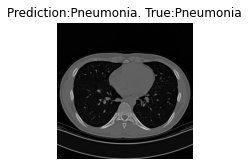

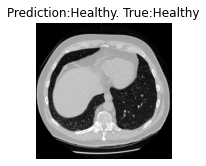

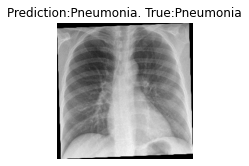

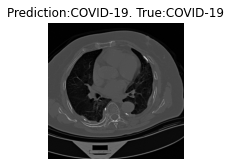

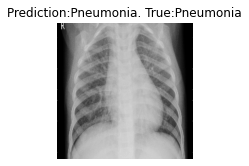

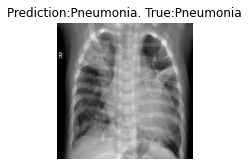

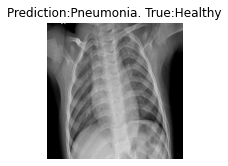

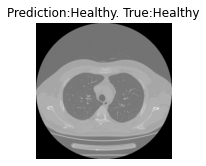

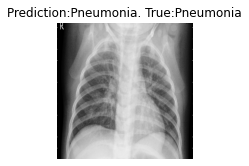

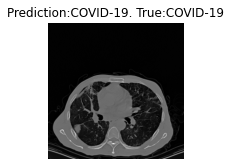

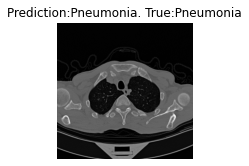

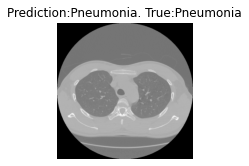

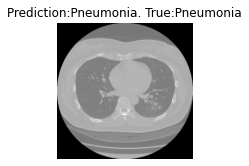

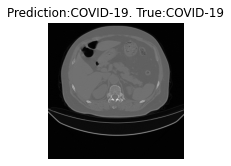

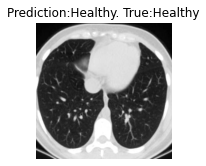

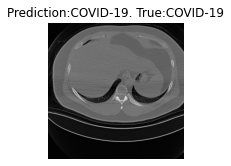

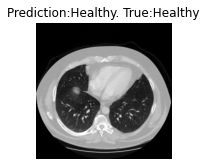

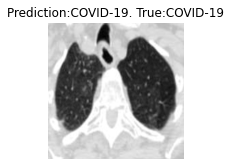

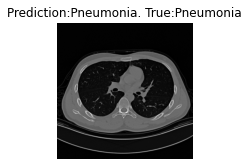

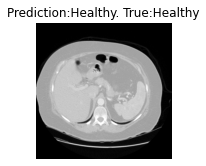

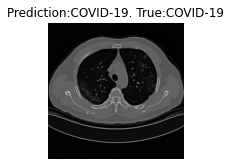

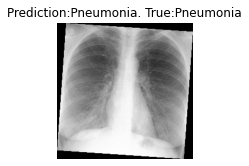

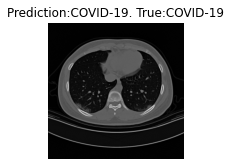

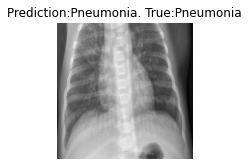

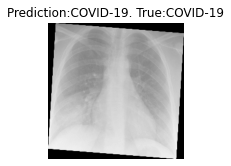

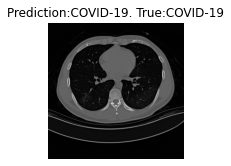

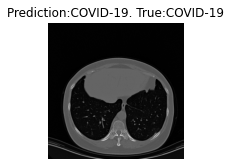

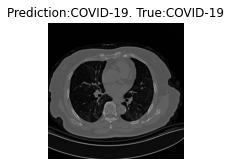

In [ ]:
def simpleargmax(n):
    if list(n).index(max(n))==0:
        return "Healthy"
    elif list(n).index(max(n))==1:
        return "COVID-19"
    else:
        return "Pneumonia"
def label(m):
    if m==0:
        return "Healthy"
    elif m==1:
        return "COVID-19"
    else:
        return "Pneumonia"
for i in range(30):
    plt.figure(figsize = (2.5,2.5))
    val=random.randint(0,len(x_test)-1)
    plt.axis("off")
    plt.imshow(x_test[val], cmap='gray')
    plt.title("Prediction:{}. True:{}".format(simpleargmax(predict[val]),label(y_test[val])))
    plt.show()